<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Codealong

_Authors: Joseph Nelson (DC)_

---

> **Note:** this codealong lesson is intended to come after the slideshow presentation and be guided in detail by the instructor.

### Learning Objectives
- Practice using statsmodels' timeseries tools on bus ridership data.
- Plot the decomposition of the timeseries.
- Conduct a Dickey-Fuller test for stationarity and plot the results.
- Perform first and second order differencing, as well as seasonal differencing on data.
- Plot ACF and PACF with European retail data.
- Examine the use of SARIMAX state-space modeling for advanced timeseries forecasting.

### Lesson Guide
- [Statsmodels timeseries tools](#statsmodels-timeseries-tools)
- [Bus ridership data](#bus-ridership-data)
	- [Clean the data](#clean-the-data)
	- [Create a date index for the data](#create-a-date-index-for-the-data)
- [Plot the riders across months](#plot-the-riders-across-months)
- [Decompose the timeseries and plot](#decompose-the-timeseries-and-plot)
- [Dickey-Fuller test of stationarity](#dickey-fuller-test-of-stationarity)
	- [Perform test on the first-differenced timeseries](#perform-test-on-the-first-differenced-timeseries)
	- [Perform test on *seasonal*-differenced timeseries](#perform-test-on-seasonal-differenced-timeseries)
	- [Perform a test on the first seasonal differenced timeseries](#perform-a-test-on-the-first-seasonal-differenced-timeseries)
- [Load the European retail data](#load-the-european-retail-data)
- [Create autocorrelation and partial autocorrelation plots](#create-autocorrelation-and-partial-autocorrelation-plots)
	- [Take a second-order difference of the retail timeseries](#take-a-second-order-difference-of-the-retail-timeseries)
- [Seasonal ARIMA with additional predictors (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
	- [Forecast using the SARIMAX model](#forecast-using-the-sarimax-model)
- [Additional resources](#additional-resources)

In [184]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels timeseries tools
---

Statsmodels (the dev version), has a wide variety of reliable timeseries analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function to decompose timeseries.

In [185]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

<a id="bus-ridership-data"></a>
## Bus ridership data
---

We are going to play around with some Portland, OR bus data. Load in the bus data below and check it out.

<a id="clean-the-data"></a>
### Clean the data

In [186]:
# data https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line
bus = pd.read_csv('./datasets/portland-oregon-average-monthly-.csv', index_col=0)
bus.index.name=None
bus.reset_index(inplace=True)
bus.head()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


There are a couple of bad rows. Get rid of them.

In [187]:
bus.tail()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


In [188]:
# A:
bus.isnull().sum()

index                                                                                         1
Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114    1
dtype: int64

Make the riders column an integer:

In [189]:
bus.drop(index=[114, 115], inplace=True)

In [190]:
bus.tail()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
109,1969-02,1425
110,1969-03,1419
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327


In [191]:
bus.iloc[:, 1] = bus.iloc[:, 1].astype(int)
bus.dtypes

index                                                                                         object
Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114     int32
dtype: object

In [192]:
bus.columns = ['Date', 'riders']

In [193]:
bus.head()

,Date,riders
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


<a id="create-a-date-index-for-the-data"></a>
### Create a date index for the data

We are going to create an artificial date index using the [`relativedelta`](http://dateutil.readthedocs.io/en/stable/relativedelta.html) function as exemplified below. We will simply start at 1973-01-01 and iterate up a month at a time.

In [194]:
# A:
date = datetime.datetime.strptime('1973-01-01', '%Y-%m-%d')
start_date = [date + relativedelta(months=x) for x in range(0,114)]
bus['Date'] = start_date
bus.set_index('Date', inplace=True)

In [195]:
bus.index.name = None

In [196]:
print(len(start_date))
print(len(bus))

114
114


<a id="plot-the-riders-across-months"></a>
## Plot the riders across months
---


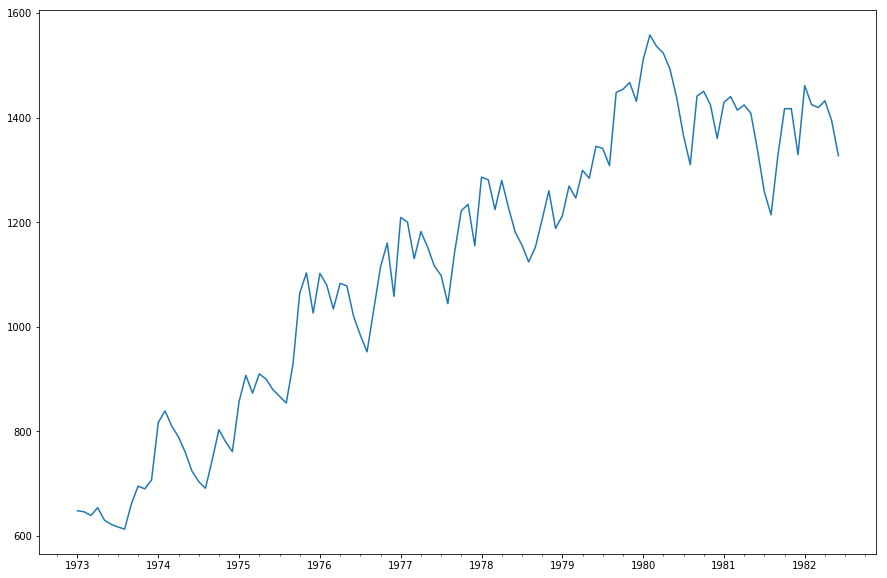

In [197]:
bus.riders.plot(figsize=(15,10))

<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the timeseries and plot
---

Using the `seasonal_decompose` function, we can break the timeseries into its constituent parts.

Use the function on the riders data with a frequency of 12, then plot the data.

> **Hint:** The decomposition object from `seasonal_decompose` has a `.plot` function like with pandas dataframes

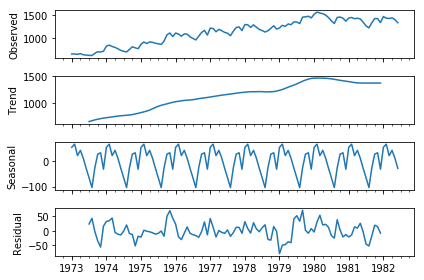

In [198]:
# A:
result = seasonal_decompose(bus, freq=12)
result.plot();

**Plot just the seasonal component.**

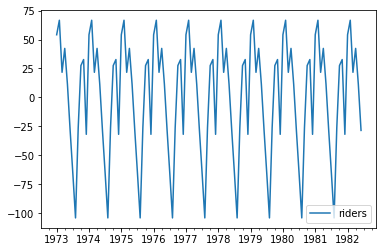

In [199]:
# A:
result.seasonal.plot();

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller test of stationarity
---

[We can perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the timeseries is stationary.


In [200]:
# here is a "helper" function
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


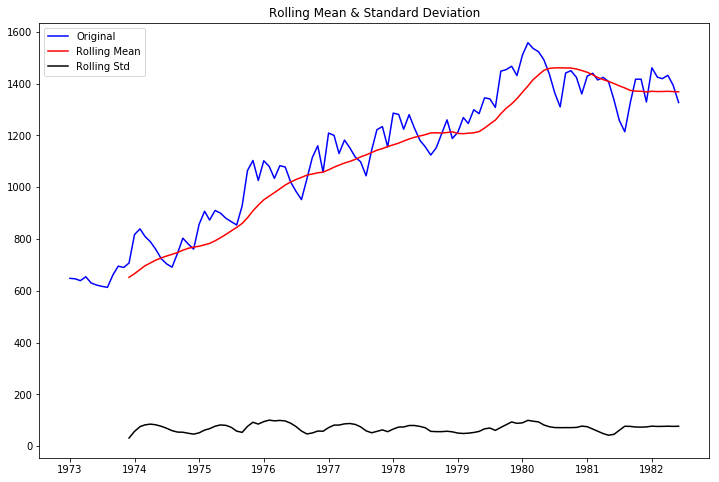

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [201]:
# perform test
test_stationarity(bus['riders'])

<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform test on the first-differenced timeseries

In [202]:
# A:
bus['diff'] = bus.riders - bus.riders.shift(1)
bus.isnull().sum()


riders    0
diff      1
dtype: int64

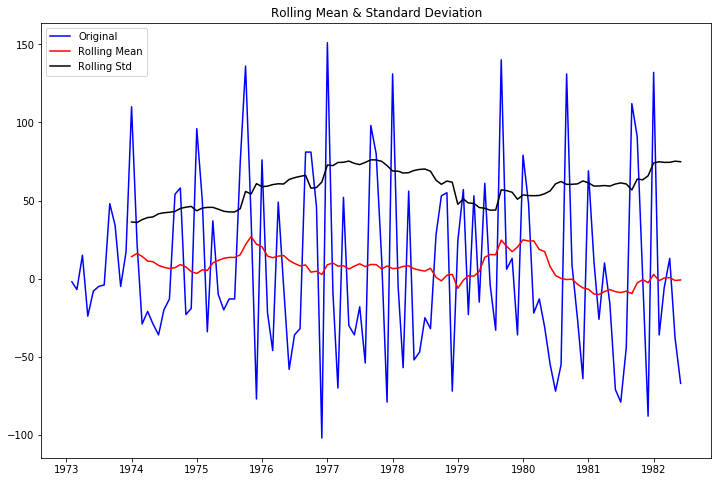

Results of Dickey-Fuller Test:


LinAlgError: SVD did not converge

In [203]:
test_stationarity(bus['diff'])

In [204]:
bus.head()

,riders,diff
1973-01-01,648,NaN
1973-02-01,646,-2.0
1973-03-01,639,-7.0
1973-04-01,654,15.0
1973-05-01,630,-24.0


<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform test on *seasonal*-differenced timeseries

Where the season will be a year's difference (12 months).

In [205]:
# A:
bus['diff2'] = bus.riders - bus.riders.shift(12)

In [206]:
bus.head()

,riders,diff,diff2
1973-01-01,648,NaN,NaN
1973-02-01,646,-2.0,NaN
1973-03-01,639,-7.0,NaN
1973-04-01,654,15.0,NaN
1973-05-01,630,-24.0,NaN


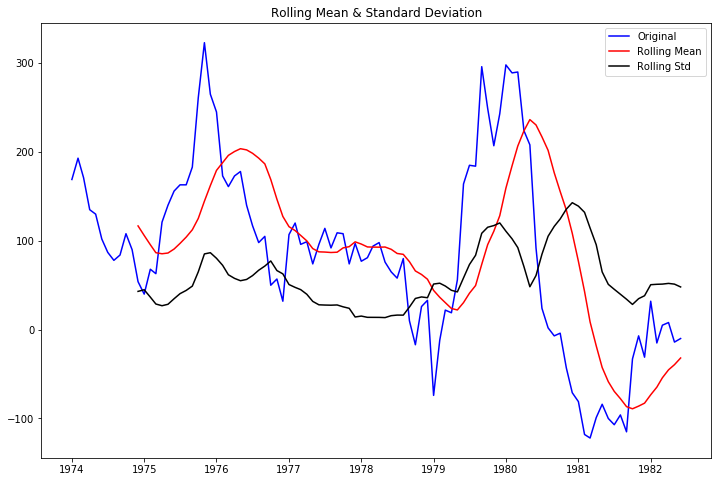

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [207]:
test_stationarity(bus['diff2'].dropna(inplace=False))

<a id="perform-a-test-on-the-first-seasonal-differenced-timeseries"></a>
### Perform a test on the first seasonal differenced timeseries

At this point we can see that we have a significant result!

In [208]:
bus.head()

,riders,diff,diff2
1973-01-01,648,NaN,NaN
1973-02-01,646,-2.0,NaN
1973-03-01,639,-7.0,NaN
1973-04-01,654,15.0,NaN
1973-05-01,630,-24.0,NaN


In [209]:
# A:
bus['seasonal_difference'] = bus['diff'] - bus['diff'].shift(12)

In [210]:
bus.head()

,riders,diff,diff2,seasonal_difference
1973-01-01,648,NaN,NaN,NaN
1973-02-01,646,-2.0,NaN,NaN
1973-03-01,639,-7.0,NaN,NaN
1973-04-01,654,15.0,NaN,NaN
1973-05-01,630,-24.0,NaN,NaN


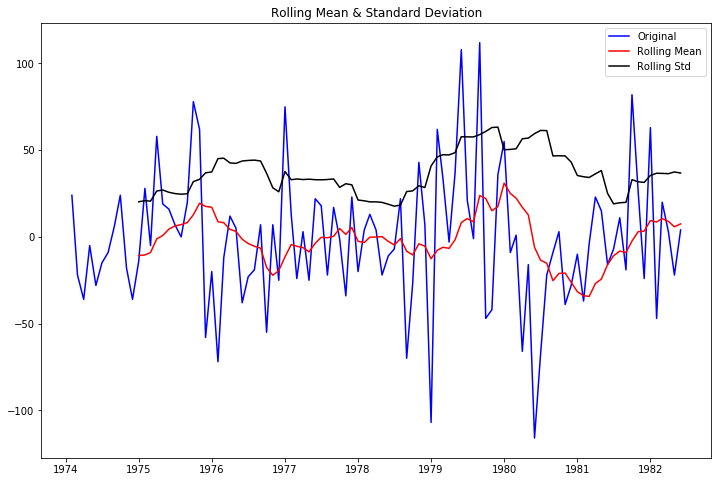

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [211]:
test_stationarity(bus['seasonal_difference'].dropna(inplace=False))

<a id="load-the-european-retail-data"></a>
## Load the European retail data
---

Make the index the year and create an initial plot of the data.

In [212]:
df = pd.read_csv('./datasets/euretail.csv')
df = df.set_index(['Year'])
df.head()


,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
1996,89.13,89.52,89.88,90.12
1997,89.19,89.78,90.03,90.38
1998,90.27,90.77,91.85,92.51
1999,92.21,92.52,93.62,94.15
2000,94.69,95.34,96.04,96.30


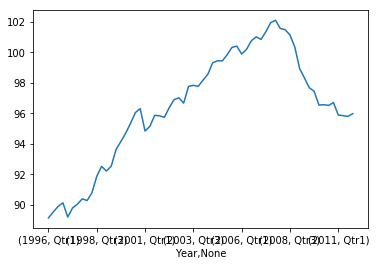

In [213]:
df.stack().plot()

<a id="create-autocorrelation-and-partial-autocorrelation-plots"></a>
## Create autocorrelation and partial autocorrelation plots 
---

Create a first-differenced timeseries of the retail data, then use `plot_acf` and `plot_pacf`.

In [214]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

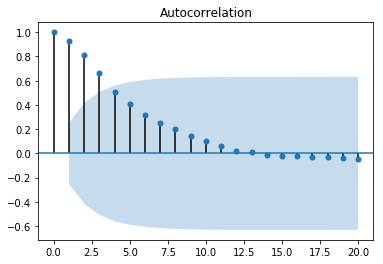

In [215]:
diff0 = df.stack().diff(periods=4)[4:]
plot_acf(diff0,lags=20);

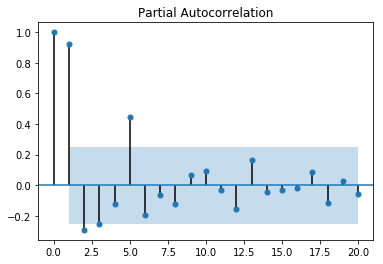

In [216]:
plot_pacf(diff0, lags=20);

<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
### Take a second-order difference of the retail timeseries

Plot the ACF and PACF again with the second-order differenced series.

In [217]:
# A:
diff1 = diff0.diff()[1:]

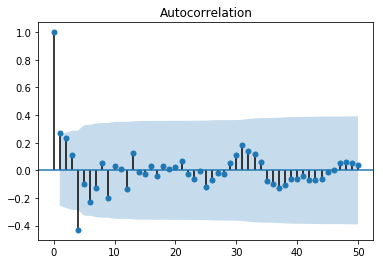

In [218]:
plot_acf(diff1, lags=50);

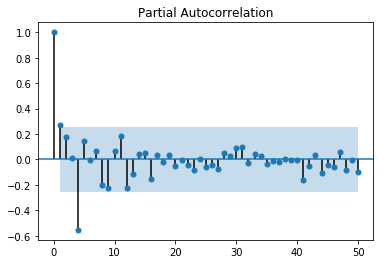

In [219]:
plot_pacf(diff1, lags=50);

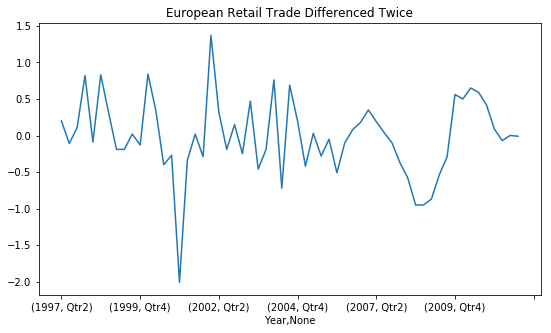

In [220]:
fig, ax = plt.subplots(figsize=(9,5))

diff1.plot(title='European Retail Trade Differenced Twice')

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA with additional predictors (SARIMAX) [New Model!!]

_We did not cover this model in class, so you should start by checking out the docs!_

---

The [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) is an advanced state space model that allows us to build a seasonal ARIMA and also take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walkthrough, but we can build a model and use it to forecast as an example of the powerful timeseries analysis capabilities that statsmodels contains.

In [221]:
data

array([  89.13,   89.52,   89.88,   90.12,   89.19,   89.78,   90.03,
         90.38,   90.27,   90.77,   91.85,   92.51,   92.21,   92.52,
         93.62,   94.15,   94.69,   95.34,   96.04,   96.3 ,   94.83,
         95.14,   95.86,   95.83,   95.73,   96.36,   96.89,   97.01,
         96.66,   97.76,   97.83,   97.76,   98.17,   98.55,   99.31,
         99.44,   99.43,   99.84,  100.32,  100.4 ,   99.88,  100.19,
        100.75,  101.01,  100.84,  101.34,  101.94,  102.1 ,  101.56,
        101.48,  101.13,  100.34,   98.93,   98.31,   97.67,   97.44,
         96.53,   96.56,   96.51,   96.7 ,   95.88,   95.84,   95.79,
         95.97])

In [222]:
import statsmodels.api as sm
data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Tue, 12 Dec 2017   AIC                             75.360
Time:                                   14:39:00   BIC                             81.837
Sample:                                        0   HQIC                            77.912
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.869      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240

**Plot the residuals of the SARIMAX model.**

In [223]:
# A:
residuals = results.resid[5:]

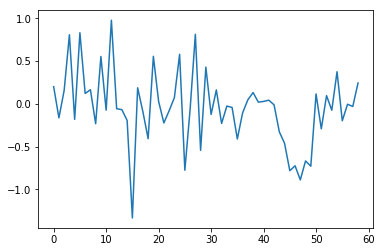

In [224]:
plt.plot(residuals)

**Plot the ACF and PACF of the residuals.**

What should we be expecting from the ACF and PACF of our residuals if the model is good?

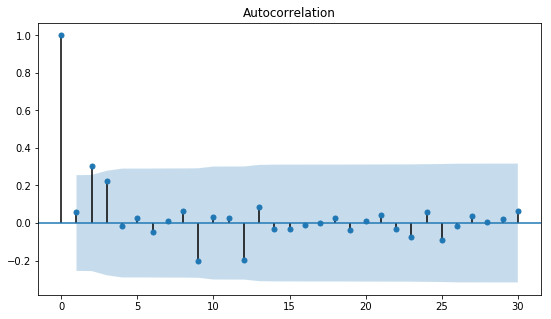

In [225]:
# A:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax);

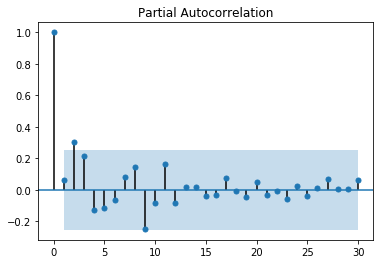

In [227]:

plot_pacf(residuals, lags=30);
plt.show()

**Increase the order of the SARIMAX model.**

How do the results change?

In [228]:
# A:
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,2), seasonal_order=(0,1,1,4))
results2 = model.fit()
print(results2.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 -32.809
Date:                           Tue, 12 Dec 2017   AIC                             73.618
Time:                                   14:40:31   BIC                             82.254
Sample:                                        0   HQIC                            77.020
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2307      0.157      1.471      0.141      -0.077       0.538
ma.L2          0.2497      0.115      2.171

<a id="forecast-using-the-sarimax-model"></a>
### Forecast using the SARIMAX model

Statsmodels result objects from SARIMAX have a `.forecast` function that can use the state space model to predict out to future timepoints.

Forecast 12 additional timepoints and plot them.

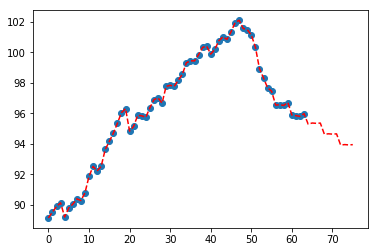

In [229]:
# forecasting
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');

<a id='additional-resources'></a>
## Additional resources
---

+ A soft introduction to [Akaike Information Criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)
+ A [video introduction](https://www.youtube.com/watch?v=YkD7ydzp9_E) to AIC
+ [Wikipedia AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
+ A Seasonal ARIMA [code-along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) from statsmodels
+ An excellent [blog code-along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython noteback](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's breakdown of available [stationarity transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ An 35min [video econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) breakdown of ARIMA
+ [Wikipedia Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ Compliments of Jonathan: a walk-through of selecting pdq from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Compliments of Jonathan pt 2: big data analytics with ARIMA [case study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ BONUS! Checkout [Granger Causality tests](https://en.wikipedia.org/wiki/Granger_causality)
